In [62]:
import numpy as np
import pandas as pd
import requests
import itertools
from datetime import datetime
from functools import partial
from tqdm import tqdm

# Model
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analytics
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import STL

# Optimization
import optuna

# Evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Declarations

In [39]:
WMO_DICT = {
    '00': 'Cloud development not observed or not observable Characteristic change of the state of sky during the past hour',
    '01': 'Clouds generally dissolving or becoming less developed Characteristic change of the state of sky during the past hour',
    '02': 'State of sky on the whole unchanged Characteristic change of the state of sky during the past hour',
    '03': 'Clouds generally forming or developing Characteristic change of the state of sky during the past hour',
    '04': 'Visibility reduced by smoke, e.g. veldt or forest fires, industrial smoke or volcanic ashes',
    '05': 'Haze',
    '06': 'Widespread dust in suspension in the air, not raised by wind at or near the station at the time of observation',
    '07': 'Dust or sand raised by wind at or near the station at the time of observation, but no well developed dust whirl(s) or sand whirl(s), and no duststorm or sandstorm seen',
    '08': 'Well developed dust whirl(s) or sand whirl(s) seen at or near the station during the preceding hour or at the time ot observation, but no duststorm or sandstorm',
    '09': 'Duststorm or sandstorm within sight at the time of observation, or at the station during the preceding hour',
    '10': 'Mist',
    '11': 'Patches shallow fog or ice fog at the station, whether on land or sea, not deeper than about 2 metres on land or 10 metres at sea',
    '12': 'More or less continuous shallow fog or ice fog at the station, whether on land or sea, not deeper than about 2 metres on land or 10 metres at sea',
    '13': 'Lightning visible, no thunder heard',
    '14': 'Precipitation within sight, not reaching the ground or the surface of the sea',
    '15': 'Precipitation within sight, reaching the ground or the surface of the sea, but distant, i.e. estimated to be more than 5 km from the station',
    '16': 'Precipitation within sight, reaching the ground or the surface of the sea, near to, but not at the station',
    '17': 'Thunderstorm, but no precipitation at the time of observation',
    '18': 'Squalls at or within sight of the station during the preceding hour or at the time of observation',
    '19': 'Funnel cloud(s) at or within sight of the station during the preceding hour or at the time of observation',
    '20': 'Drizzle (not freezing) or snow grains not falling as shower(s)',
    '21': 'Rain (not freezing) not falling as shower(s)',
    '22': 'Snow not falling as shower(s)',
    '23': 'Rain and snow or ice pellets not falling as shower(s)',
    '24': 'Freezing drizzle or freezing rain not falling as shower(s)',
    '25': 'Shower(s) of rain',
    '26': 'Shower(s) of snow, or of rain and snow',
    '27': 'Shower(s) of hail, or of rain and hail',
    '28': 'Fog or ice fog',
    '29': 'Thunderstorm (with or without precipitation)',
    '30': 'Slight or moderate duststorm or sandstorm - has decreased during the preceding hour',
    '31': 'Slight or moderate duststorm or sandstorm - no appreciable change during the preceding hour',
    '32': 'Slight or moderate duststorm or sandstorm - has begun or has increased during the preceding hour',
    '33': 'Severe duststorm or sandstorm - has decreased during the preceding hour',
    '34': 'Severe duststorm or sandstorm - no appreciable change during the preceding hour',
    '35': 'Severe duststorm or sandstorm - has begun or has increased during the preceding hour',
    '36': 'Slight or moderate blowing snow generally low (below eye level)',
    '37': 'Heavy drifting snow generally low (below eye level)',
    '38': 'Slight or moderate blowing snow generally high (above eye level)',
    '39': 'Heavy drifting snow generally high (above eye level)',
    '40': 'Fog or ice fog at a distance at the time of observation, but not at the station during the preceding hour, the fog or ice fog extending to a level above that of the observer',
    '41': 'Fog or ice fog in patches',
    '42': 'Fog or ice fog, sky visible has become thinner during the preceding hour',
    '43': 'Fog or ice fog, sky invisible has become thinner during the preceding hour',
    '44': 'Fog or ice fog, sky visible no appreciable change during the preceding hour',
    '45': 'Fog or ice fog, sky invisible no appreciable change during the preceding hour',
    '46': 'Fog or ice fog, sky visible has begun or has become thicker during the preceding hour',
    '47': 'Fog or ice fog, sky invisible has begun or has become thicker during the preceding hour',
    '48': 'Fog, depositing rime, sky visible',
    '49': 'Fog, depositing rime, sky invisible',
    '50': 'Drizzle, not freezing, intermittent slight at time of observation',
    '51': 'Drizzle, not freezing, continuous slight at time of observation',
    '52': 'Drizzle, not freezing, intermittent moderate at time of observation',
    '53': 'Drizzle, not freezing, continuous moderate at time of observation',
    '54': 'Drizzle, not freezing, intermittent heavy (dense) at time of observation',
    '55': 'Drizzle, not freezing, continuous heavy (dense) at time of observation',
    '56': 'Drizzle, freezing, slight',
    '57': 'Drizzle, freezing, moderate or heavy (dence)',
    '58': 'Drizzle and rain, slight',
    '59': 'Drizzle and rain, moderate or heavy',
    '60': 'Rain, not freezing, intermittent slight at time of observation',
    '61': 'Rain, not freezing, continuous slight at time of observation',
    '62': 'Rain, not freezing, intermittent moderate at time of observation',
    '63': 'Rain, not freezing, continuous moderate at time of observation',
    '64': 'Rain, not freezing, intermittent heavy at time of observation',
    '65': 'Rain, not freezing, continuous heavy at time of observation',
    '66': 'Rain, freezing, slight',
    '67': 'Rain, freezing, moderate or heavy (dence)',
    '68': 'Rain or drizzle and snow, slight',
    '69': 'Rain or drizzle and snow, moderate or heavy',
    '70': 'Intermittent fall of snowflakes slight at time of observation',
    '71': 'Continuous fall of snowflakes slight at time of observation',
    '72': 'Intermittent fall of snowflakes moderate at time of observation',
    '73': 'Continuous fall of snowflakes moderate at time of observation',
    '74': 'Intermittent fall of snowflakes heavy at time of observation',
    '75': 'Continuous fall of snowflakes heavy at time of observation',
    '76': 'Diamond dust (with or without fog)',
    '77': 'Snow grains (with or without fog)',
    '78': 'Isolated star-like snow crystals (with or without fog)',
    '79': 'Ice pellets',
    '80': 'Rain shower(s), slight',
    '81': 'Rain shower(s), moderate or heavy',
    '82': 'Rain shower(s), violent',
    '83': 'Shower(s) of rain and snow mixed, slight',
    '84': 'Shower(s) of rain and snow mixed, moderate or heavy',
    '85': 'Snow shower(s), slight',
    '86': 'Snow shower(s), moderate or heavy',
    '87': 'Shower(s) of snow pellets or small hail, with or without rain or rain and snow mixed - slight',
    '88': 'Shower(s) of snow pellets or small hail, with or without rain or rain and snow mixed - moderate or heavy',
    '89': 'Shower(s) of hail, with or without rain or rain and snow mixed, not associated with thunder - slight',
    '90': 'Shower(s) of hail, with or without rain or rain and snow mixed, not associated with thunder - moderate or heavy',
    '91': 'Slight rain at time of observation Thunderstorm during the preceding hour but not at time of observation',
    '92': 'Moderate or heavy rain at time of observation Thunderstorm during the preceding hour but not at time of observation',
    '93': 'Slight snow, or rain and snow mixed or hail at time of observation Thunderstorm during the preceding hour but not at time of observation',
    '94': 'Moderate or heavy snow, or rain and snow mixed or hail at time of observation Thunderstorm during the preceding hour but not at time of observation',
    '95': 'Thunderstorm, slight or moderate, without hail but with rain and/or snow at time of observation Thunderstorm at time of observation',
    '96': 'Thunderstorm, slight or moderate, with hail at time of observation Thunderstorm at time of observation',
    '97': 'Thunderstorm, heavy, without hail but with rain and/or snow at time of observation Thunderstorm at time of observation',
    '98': 'Thunderstorm combined with duststorm or sandstorm at time of observation Thunderstorm at time of observation',
    '99': 'Thunderstorm, heavy, with hail at time of observation Thunderstorm at time of observation',
}

In [40]:
START_DATE = '2015-05-17'
END_DATE = '2025-05-17'

if int(END_DATE.split('-')[0]) - int(START_DATE.split('-')[0]) > 1:
    print('WARNING: YOU ARE GOING TO REQUEST MORE THAN ONE YEAR\'S WORTH OF DATA FROM THE API.\n\tTHIS WILL COST YOU A LOT OF API CALLS (UPWARDS OF HUNDREDS).\n\tPLEASE BE SURE YOU ARE NOT RUNNING THIS MULTIPLE TIMES AS IT WILL DEPLETE YOUR DAILY LIMIT!')

OPEN_METEO_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude=-7.95&longitude=112.61&start_date={START_DATE}&end_date={END_DATE}&hourly=temperature_2m,is_day,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m&timezone=auto"

	THIS WILL COST YOU A LOT OF API CALLS (UPWARDS OF HUNDREDS).
	PLEASE BE SURE YOU ARE NOT RUNNING THIS MULTIPLE TIMES AS IT WILL DEPLETE YOUR DAILY LIMIT!


# Get data

In [41]:
def get_open_meteo():
    try:
        res = requests.get(OPEN_METEO_URL)
        if res.status_code == 200:
            data = res.json()
        else:
            print(res.status_code)
    except Exception as e:
        print(e)
        return None
    return data

In [ ]:
# Please change this to be True to be sure that you are going to call the API
# This is to prevent you from depleting your API call limit of 10,000 (ten thousand) 

# Don't forget to change it back to False or keep it equal to False
CONFIRMATION = False

if CONFIRMATION and (int(END_DATE.split('-')[0]) - int(START_DATE.split('-')[0]) > 1):
    print('Getting data...')
    data = get_open_meteo()

Getting data...


In [43]:
descriptor = pd.DataFrame({
    'latitude': [data['latitude']],
    'longitude': [data['longitude']],
    'utc_offset_seconds': [data['utc_offset_seconds']],
    'timezone': [data['timezone']],
    'timezone_abbreviation': [data['timezone_abbreviation']]
})
descriptor.head()

,latitude,longitude,utc_offset_seconds,timezone,timezone_abbreviation
0,-7.97891,112.59608,25200,Asia/Jakarta,GMT+7


In [44]:
final = pd.DataFrame({
    'datetime': data['hourly']['time'],
    'temperature_2m': data['hourly']['temperature_2m'],
    'is_day': data['hourly']['is_day'],
    'relative_humidity_2m': data['hourly']['relative_humidity_2m'],
    'dew_point_2m': data['hourly']['dew_point_2m'],
    'apparent_temperature': data['hourly']['apparent_temperature'],
    'precipitation': data['hourly']['precipitation'],
    'weather_code': data['hourly']['weather_code'],
    'pressure_msl': data['hourly']['pressure_msl'],
    'surface_pressure': data['hourly']['surface_pressure'],
    'cloud_cover': data['hourly']['cloud_cover'],
    'cloud_cover_low': data['hourly']['cloud_cover_low'],
    'cloud_cover_mid': data['hourly']['cloud_cover_mid'],
    'cloud_cover_high': data['hourly']['cloud_cover_high'],
    'et0_fao_evapotranspiration': data['hourly']['et0_fao_evapotranspiration'],
    'vapour_pressure_deficit': data['hourly']['vapour_pressure_deficit'],
    'wind_speed_10m': data['hourly']['wind_speed_10m'],
    'wind_direction_10m': data['hourly']['wind_direction_10m'],
    'wind_gusts_10m': data['hourly']['wind_gusts_10m'],
})

In [46]:
final.head()

,datetime,temperature_2m,is_day,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2015-05-17T00:00,20.9,0,95.0,20.1,23.6,0.0,0.0,1012.9,955.8,18.0,17.0,0.0,0.0,0.0,0.12,7.9,93.0,17.6
1,2015-05-17T01:00,20.5,0,97.0,20.0,23.2,0.0,1.0,1012.4,955.3,25.0,24.0,0.0,0.0,0.0,0.07,8.3,95.0,17.6
2,2015-05-17T02:00,21.4,0,94.0,20.5,24.4,0.0,1.0,1011.8,954.9,25.0,25.0,0.0,0.0,0.0,0.14,7.9,93.0,19.4
3,2015-05-17T03:00,21.1,0,95.0,20.3,24.1,0.0,1.0,1011.5,954.5,22.0,21.0,0.0,0.0,0.0,0.11,7.2,87.0,19.1
4,2015-05-17T04:00,20.6,0,97.0,20.0,23.5,0.0,1.0,1011.9,954.8,20.0,19.0,0.0,0.0,0.0,0.08,6.9,81.0,18.4


In [45]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87696 entries, 0 to 87695
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   datetime                    87696 non-null  object 
 1   temperature_2m              87680 non-null  float64
 2   is_day                      87696 non-null  int64  
 3   relative_humidity_2m        87680 non-null  float64
 4   dew_point_2m                87680 non-null  float64
 5   apparent_temperature        87680 non-null  float64
 6   precipitation               87680 non-null  float64
 7   weather_code                87680 non-null  float64
 8   pressure_msl                87680 non-null  float64
 9   surface_pressure            87680 non-null  float64
 10  cloud_cover                 87680 non-null  float64
 11  cloud_cover_low             87680 non-null  float64
 12  cloud_cover_mid             87680 non-null  float64
 13  cloud_cover_high            876

## Export data

In [47]:
try:
    descriptor.to_csv('../data/ub_historical_descriptor.csv', index=False)
    final.to_csv('../data/ub_historical_data.csv', index=False)
except Exception as e:
    print(e)

# Modeling

In [72]:
df = pd.read_csv('../data/ub_historical_data.csv')

In [79]:
df.tail()

,datetime,temperature_2m,is_day,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,wind_gusts_10m
87691,2025-05-17T19:00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87692,2025-05-17T20:00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87693,2025-05-17T21:00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87694,2025-05-17T22:00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87695,2025-05-17T23:00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Terlihat bahwa tidak ada nilai yang kosong kecuali di bagian akhir atau tail dari dataframe.

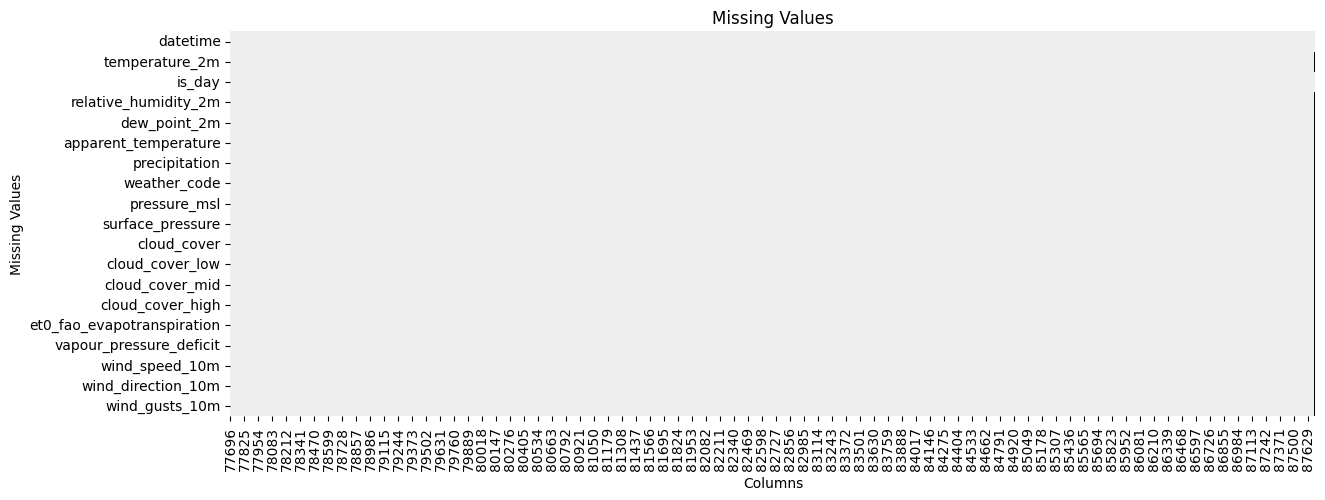

In [ ]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#EEEEEE', 'black']) 

ax = plt.axes()
ax.figure.set_size_inches(14, 5)

sns.heatmap(df.isna().transpose(), cmap=custom_cmap, cbar=False, ax=ax)

plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize=10) 
plt.ylabel('Missing Values', fontsize=10)

plt.show()

Warna hitam menandakan bahwa terdapat nilai-nilai kosong

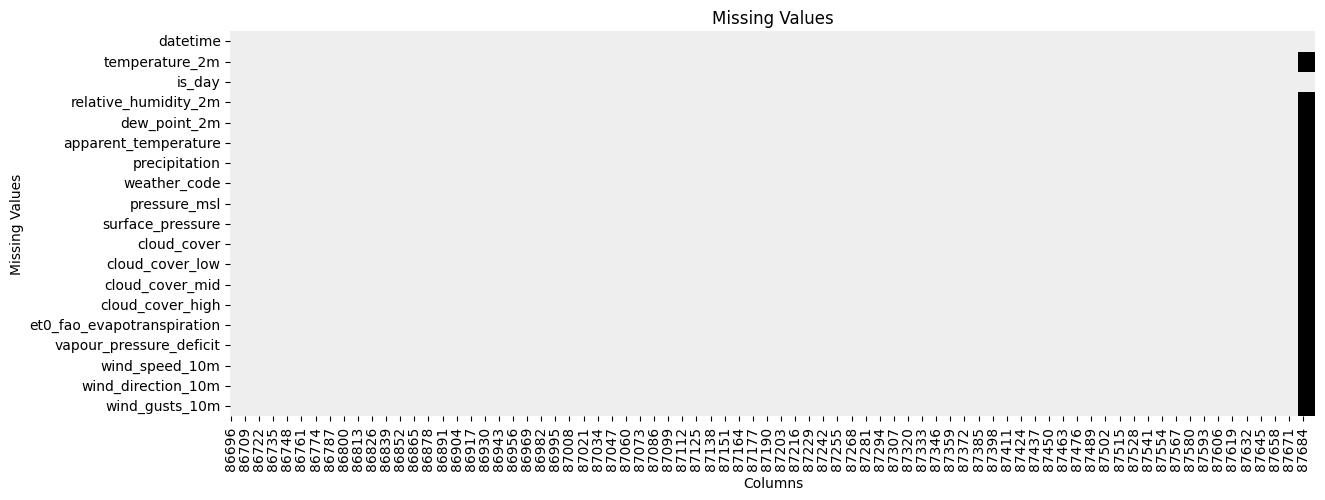

In [77]:
custom_cmap = ListedColormap(['#EEEEEE', 'black']) 

ax = plt.axes()
ax.figure.set_size_inches(14, 5)

sns.heatmap(df.iloc[-1000:].isna().transpose(), cmap=custom_cmap, cbar=False, ax=ax)

plt.title('Missing Values', fontsize=12)
plt.xlabel('Columns', fontsize=10) 
plt.ylabel('Missing Values', fontsize=10)

plt.show()

## Prophet class

In [139]:
class ProphetWeather:
    @classmethod
    def _init(self, data_loc):
        self.ppdf: list[pd.DataFrame] = []
        try:
            self.data = pd.read_csv(data_loc)
        except Exception as e:
            print(e)
            print("Please provide your own dataframe by calling _set_df()")
    
    def _set_df(self, df: pd.DataFrame):
        self.data = df.copy()

    def _z_normalise(self, data, column):
        avg = np.average(data[column].values)
        stddev = np.std(data[column].values)
        res = data[column].apply(lambda x: (x - avg) / stddev)

        return res, avg, stddev
    
    def _z_unnormalise(self, data, column, avg, stddev):
        res = data[column].apply(lambda z: z * stddev + avg)

        return res
    
    def _get_prepared_data(
            self, 
            target_column, 
            set_rest_as_regressors=True,
            regressor_columns: list = None,
            date_column='datetime'
    ):
        self.date_column = date_column

        df = pd.DataFrame()

        old_ds = self.data[date_column]
        rf_ds = []

        for ds in old_ds:
            res = str(ds).split("T")
            res[1] = res[1] + ':00'
            rf_ds.append(' '.join([res[0], res[1]]))

        df['ds'] = rf_ds
        df['y'] = self.data[target_column]

        if set_rest_as_regressors:
            for col in self.data.columns:
                if col != target_column and col != date_column:
                    df[col] = self.data[col]
        else:
            for col in regressor_columns:
                if col != target_column and col != date_column and col in regressor_columns:
                    df[col] = self.data[col]

        # Just in case there historical API does not have most recent data archived,
        # remove the last 24 hours of data
        df.drop(df.tail(24).index, inplace=True)
       
        return df
    
    def _plot_from_clipped_dates(
            self, 
            y_train,
            y_test, 
            y_predict, 
            date_df_train, 
            date_df_test, 
            previous_dates=10, 
            column=None
    ):
        y_predict_np = np.array(y_predict).flatten()
        y_predict_np = np.insert(y_predict_np, 0, y_train.iloc[-1])

        date_df_test_plot = pd.concat([date_df_train[-previous_dates:], date_df_test])

        y_test_plot = pd.concat([y_train[-previous_dates:], y_test])

        date_df_pred = date_df_test
        date_df_pred = np.insert(date_df_pred, 0, date_df_train.iloc[-1])

        plt.figure(figsize=(12, 5))

        # Plot test data
        plt.plot(date_df_test_plot, y_test_plot.values, label='Test Data', color='royalblue', linestyle='-')

        # Plot training data
        plt.plot(date_df_train[-previous_dates:], y_train[-previous_dates:].values, label='Train Data', color='deepskyblue')

        # Plot predicted data
        plt.plot(date_df_pred, y_predict_np, label='forecast', color='darkorange', linestyle='-')

        # Styling
        plt.title(f'{column} forecasting result', fontsize=16)
        plt.xlabel('date', fontsize=12)
        plt.ylabel(column, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.xticks(rotation=90)

        plt.show()
    
    def _train(
            self, 
            forecast_length=24,
            set_rest_as_regressors=True,
            regressor_columns: list = None,
            default_target_cols=True,
            custom_target_cols: list = None
    ):
        target_cols = []
        if default_target_cols:
            target_cols = ['temperature_2m', 'precipitation']
        else:
            target_cols = custom_target_cols

        for col in target_cols:
            res = self._get_prepared_data(col)
            self.ppdf.append(res)

        for i in tqdm(range(len(self.ppdf))):
            model = Prophet(
                holidays=None,
                daily_seasonality=True,
            )

            data_train = self.ppdf[i].iloc[:-forecast_length]
            data_test = self.ppdf[i].iloc[-forecast_length:]

            if target_cols[i] == 'precipitation':
                train_res, train_avg, train_stddev = self._z_normalise(data_train, 'y')
                test_res, test_avg, test_stddev = self._z_normalise(data_test, 'y')
                data_train.loc[:, 'y'] = train_res
                data_test.loc[:, 'y'] = test_res

            if set_rest_as_regressors:
                for col in self.data.columns:
                    if col != target_cols[i] and col != self.date_column:
                        model.add_regressor(col)
            else:
                for col in regressor_columns:
                    if col != target_cols[i] and col != self.date_column and col in regressor_columns:
                        model.add_regressor(col)

            model = model.fit(data_train)

            # Create future dates
            last_train_date = data_train['ds'].max()
            future_dates_ds = model.make_future_dataframe(periods=forecast_length, freq='h')

            # Filter to only include actual future dates beyond training data
            future_only_dates_ds = future_dates_ds[future_dates_ds['ds'] > last_train_date].copy()
            
            if set_rest_as_regressors:
                for col in self.data.columns:
                    if col != target_cols[i] and col != self.date_column:
                        # Populate test set with each regressor used
                        future_only_dates_ds[col] = data_test[col].values
            else:
                for col in regressor_columns:
                    if col != target_cols[i] and col != self.date_column and col in regressor_columns:
                        # Populate test set with each regressor used
                        future_only_dates_ds[col] = data_test[col].values

            forecast = model.predict(future_only_dates_ds)

            if target_cols[i] == 'precipitation':
                self._eval(data_test['y'], self._z_unnormalise(forecast, 'yhat', test_avg, test_stddev))

                self._plot_from_clipped_dates(
                    self._z_unnormalise(data_train, 'y', train_avg, train_stddev), 
                    self._z_unnormalise(data_test, 'y', test_avg, test_stddev), 
                    self._z_unnormalise(forecast, 'yhat', test_avg, test_stddev), 
                    data_train['ds'], 
                    data_test['ds'], 
                    previous_dates=48,
                    column=target_cols[i]
                )
            else:
                self._eval(data_test['y'], forecast['yhat'])

                self._plot_from_clipped_dates(
                    data_train['y'], 
                    data_test['y'], 
                    forecast['yhat'], 
                    data_train['ds'], 
                    data_test['ds'], 
                    previous_dates=48,
                    column=target_cols[i]
                )
                
            # fig = model.plot(forecast)
            # fig.set_size_inches(12,6)
            # plt.show()

    def _eval(self, y_test, y_predict):
        rmse = root_mean_squared_error(y_test, y_predict)
        mae = mean_absolute_error(y_test, y_predict)
        mape = mean_absolute_percentage_error(y_test, y_predict)

        print(f"RMSE: {rmse} | MAE: {mae}, | MAPE: {mape}")

    def forecast(self):
        self._train()

  0%|          | 0/2 [00:00<?, ?it/s]18:29:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.08096057873997888 | MAE: 0.05884129409563702, | MAPE: 0.0024715590622050735


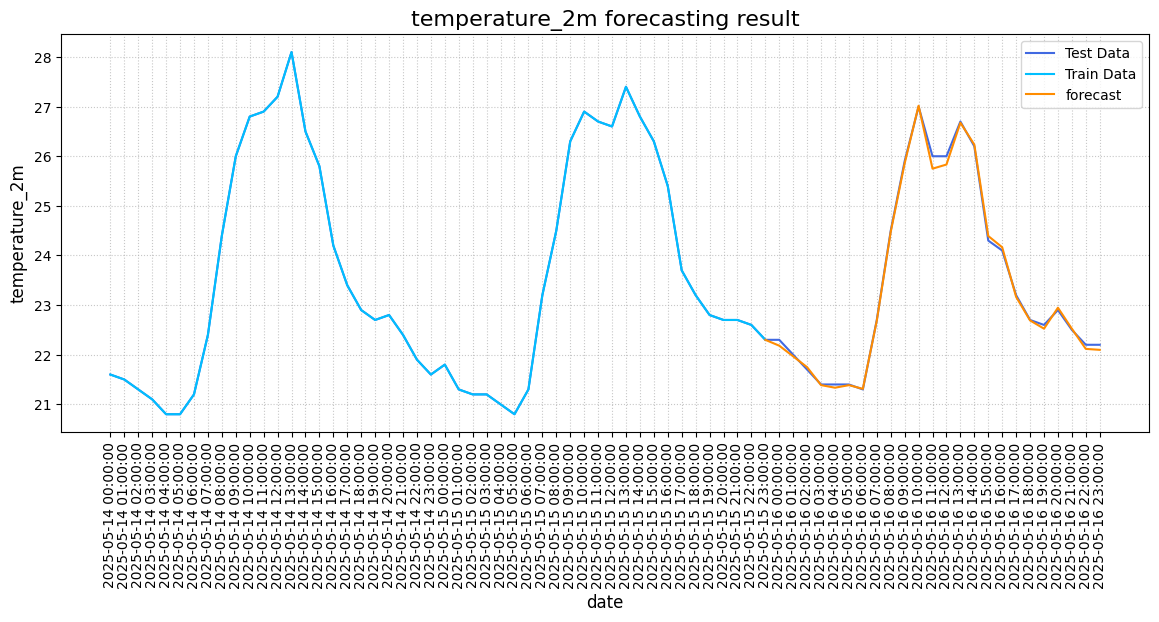

 50%|█████     | 1/2 [00:49<00:49, 49.56s/it]18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.7465809446796015 | MAE: 1.5704527834509492, | MAPE: 5.810703422860162


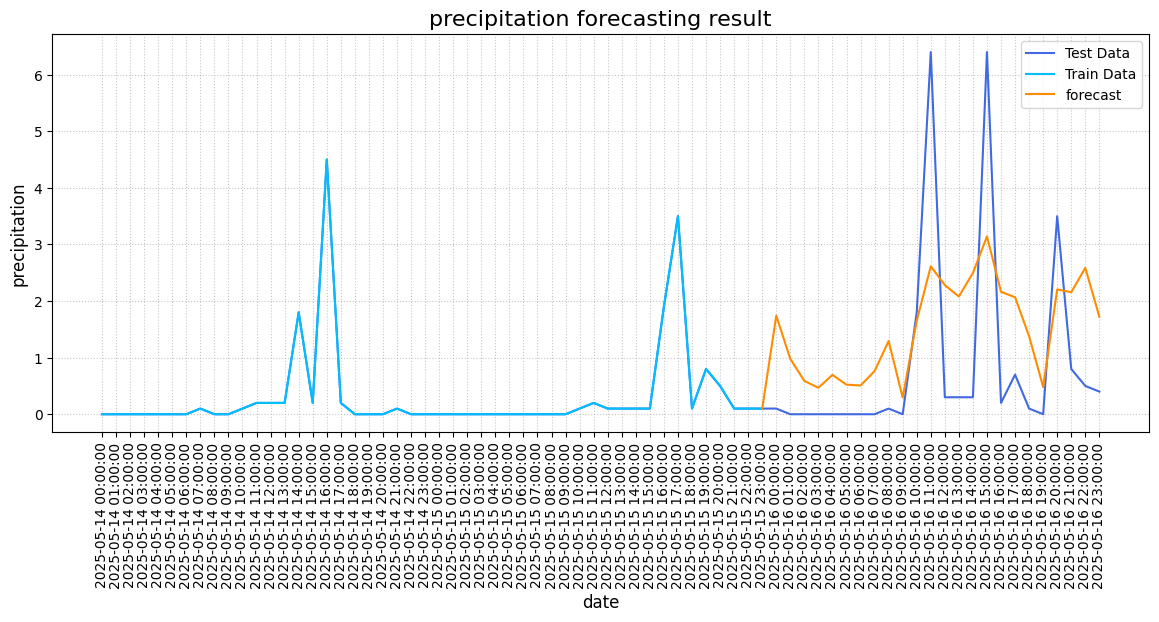

100%|██████████| 2/2 [01:37<00:00, 48.67s/it]


In [140]:
pw = ProphetWeather()
pw._init('../data/ub_historical_data.csv')
pw.forecast()